## European Cities 1D [Part 1]

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim

paris_coords = np.array([
    [48.8575, 2.3514], #Center of Paris
    [48.8584, 2.2945], # Eiffel Tower
    [48.8530, 2.3499], #Notre Dame
    [48.8606,  2.3376], #Louvre
    [48.8606, 2.3522]  #Centre Pompidou
])

madrid_coords = np.array([
    [40.4167, -3.7033],   # Center of Madrid
    [40.4153, -3.6835],   # Retiro Park 
    [40.4180, -3.7143],   # Royal Palace 
    [40.4138, -3.6921],   # Prado Museum 
    [40.4169, -3.7033]   # Puerta del Sol 
])

berlin_coords = np.array([
    [52.5200, 13.4050], # Center of Berlin
    [52.5163, 13.3777],   # Brandenburg Gate 
    [52.5169, 13.4019],   # Museum Island 
    [52.5074, 13.3904],   # Checkpoint Charlie 
    [52.5251, 13.3694]   # Berlin Central Station 
])

colors=['c', 'y', 'm']

In [2]:
# Set random seed for reproducibility
random_seed=52
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
# Combine data into one matrix X and labels y
X_raw = np.vstack([madrid_coords, paris_coords, berlin_coords]) #, brussels_coords, vienna_coords])
y = np.array([0, 0, 0, 0, 0,  #  Madrid labels (0)
              1, 1, 1, 1, 1,  #  Paris labels (1)
              2, 2, 2, 2, 2]) #, # Berlin labels (2)
              #3, 3, 3, 3, 3, 3, 3, 
              #4, 4, 4, 4, 4, 4, 4]) 

# Let's use only longitude as input for the simple model
X_lon = X_raw[:, 1].reshape(-1, 1)  # Extract longitude and reshape to column vector

# Normalize data (simple scaling by dividing by 100, I guess I could do 10)
X = X_lon # / 100 - Simple longitude only problem does not seem to require normalization, that's interesting!

# Alternative normalization (uncomment to use)
# mean = np.mean(X_lon)
# std = np.std(X_lon)
# X = (X_lon - mean) / std

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]
X_raw=X_raw[rI,:]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (15, 1)
Shape of y: (15,)


In [4]:
class TinyGPSModel(nn.Module):
    def __init__(self, input_size=1, output_size=3):
        super(TinyGPSModel, self).__init__()
        self.output = nn.Linear(input_size, output_size) #, bias=False)  # 3 cities

    def forward(self, x):
        x = self.output(x)
        return x

In [5]:
# Initialize model, loss, and optimizer
model = TinyGPSModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

#I can manually initialize and still learns real good? yeah seems like it!
with torch.no_grad():
    model.output.weight[0,0]=1.0
    model.output.weight[1,0]=0.0
    model.output.weight[2,0]=-1.0
    model.output.bias[0]=0
    model.output.bias[1]=0
    model.output.bias[2]=0

In [6]:
logits=model(torch.tensor([2.3514])).detach() #Center of Paris
logits

tensor([ 2.3514,  0.0000, -2.3514])

In [7]:
torch.nn.Softmax(0)(logits)

tensor([0.9055, 0.0862, 0.0082])

In [8]:
-np.log(0.0862)

2.4510851013124895

In [9]:
with torch.no_grad():
    model.output.weight[0,0]=1.0
    model.output.weight[1,0]=0.1
    model.output.weight[2,0]=-1.0
    model.output.bias[0]=0
    model.output.bias[1]=0
    model.output.bias[2]=0

In [10]:
logits=model(torch.tensor([2.3514])).detach() #Center of Paris
logits

tensor([ 2.3514,  0.2351, -2.3514])

In [11]:
torch.nn.Softmax(0)(logits)

tensor([0.8853, 0.1067, 0.0080])

In [12]:
# Initialize model, loss, and optimizer
model = TinyGPSModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

#I can manually initialize and still learns real good? yeah seems like it!
with torch.no_grad():
    model.output.weight[0,0]=1.0
    model.output.weight[1,0]=0.0
    model.output.weight[2,0]=-1.0
    model.output.bias[0]=0
    model.output.bias[1]=0
    model.output.bias[2]=0

In [13]:
i=14 #Center of Paris
X[i%len(y)] 

array([2.3514])

In [14]:
outputs = model(torch.tensor(X[i%len(y)]).float())
loss = criterion(outputs, torch.tensor(y[i%len(y)])) 
loss.backward()  # backpropagation

In [15]:
model.output.weight.grad

tensor([[ 2.1293],
        [-2.1486],
        [ 0.0193]])

In [16]:
model.output.bias.grad

tensor([ 0.9055, -0.9138,  0.0082])

In [17]:
(0.0862-1)*2.3522

-2.14944036

## Heatmaps

In [18]:
#Where to save training heatmaps
save_dir='/Users/stephen/Stephencwelch Dropbox/Stephen Welch/welch_labs/backprop2/graphics/to_manim/may_27_3'

In [19]:
#Swaggin - need to sync with Sam on exact numbers
min_long=-7.0
max_long=18.0
min_lat=36.0
max_lat=56.0
num_steps=256
heatmap_viz_logit_multiplier=8 #Makes things more winner take all for cleaner logit viz
heatmaps=[np.zeros((num_steps, num_steps)) for i in range(6)]

for i, lat in enumerate(np.linspace(max_lat, min_lat, num_steps)):
    for j, long in enumerate(np.linspace(min_long, max_long, num_steps)):
        with torch.no_grad():
            logits=model(torch.tensor([long], dtype=torch.float)).detach()
            yhat=torch.nn.Softmax(0)(heatmap_viz_logit_multiplier*logits).numpy()

        for k in range(3):
            heatmaps[k][i,j]=logits.numpy()[k]
            heatmaps[k+3][i,j]=yhat[k]

In [20]:
heatmaps[0].shape

(256, 256)

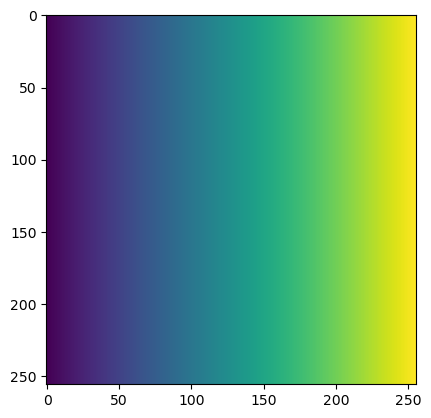

In [21]:
plt.imshow(heatmaps[0])

In [22]:
import matplotlib.colors as mcolors
def create_transparent_colormap(color='cyan', name='transparent_to_color'):
    # Convert color name to RGBA
    base_color = mcolors.to_rgba(color)
    
    # Create colormap: transparent (alpha=0) to full color (alpha=1)
    colors = [(base_color[0], base_color[1], base_color[2], 0),  # transparent
              (base_color[0], base_color[1], base_color[2], 1)]  # full color
    
    n_bins = 256
    cmap = mcolors.LinearSegmentedColormap.from_list(name, colors, N=n_bins)
    return cmap

# Create the colormap
transparent_cyan_cmap = create_transparent_colormap('cyan')
transparent_yellow_cmap = create_transparent_colormap('#ffd35a')
transparent_green_cmap = create_transparent_colormap('#00a14b')

In [23]:
cmaps=[transparent_cyan_cmap, transparent_yellow_cmap, transparent_green_cmap, transparent_cyan_cmap, transparent_yellow_cmap, transparent_green_cmap]
save_names=['_logits_1.png', '_logits_2.png', '_logits_3.png', '_yhat_1.png', '_yhat_2.png', '_yhat_3.png']

# for l in range(6):
#     plt.clf()
#     plt.figure(frameon=False)
#     ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
#     ax.set_axis_off()
#     plt.gcf().add_axes(ax)
#     plt.imshow(heatmaps[l],  cmap=cmaps[l]) #np.rot90(heatmaps[0])) #Wait and see if I need to rotate or transpose
#     plt.savefig(save_dir+save_names[l], bbox_inches='tight', pad_inches=0, dpi=300)
#     plt.close()

In [24]:
# Initialize model, loss, and optimizer
model = TinyGPSModel()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.05)

#I can manually initialize and still learns real good? yeah seems like it!
with torch.no_grad():
    model.output.weight[0,0]=1.0
    model.output.weight[1,0]=0.0
    model.output.weight[2,0]=-1.0
    model.output.bias[0]=0
    model.output.bias[1]=0
    model.output.bias[2]=0

weights=[]
grads=[]
xs=[]
ys=[]
logitss=[]
yhats=[]

# Training loop
for i in range(350):
    xs.append(X_raw[i%len(y)])
    ys.append(y[i%len(y)])
    weights.append(np.concatenate([model.output.weight.detach().numpy().ravel(), model.output.bias.detach().numpy().ravel()]))
    
    optimizer.zero_grad()
    
    #Stochastic - i think this is a better starting point pedagogically. 
    outputs = model(torch.tensor(X[i%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[i%len(y)])) 

    logitss.append(outputs.detach().numpy())
    yhats.append(torch.nn.Softmax(0)(outputs.detach()).numpy())
    
    loss.backward()  # backpropagation
    grads.append(np.concatenate([model.output.weight.grad.detach().numpy().ravel(), model.output.bias.grad.detach().numpy().ravel()]))
    optimizer.step() #
    
    if (i + 1) % 10 == 0:
        with torch.no_grad():
            logits=model(torch.tensor(X, dtype=torch.float)) 
            accuracy=(torch.argmax(logits, dim=1)==torch.tensor(y)).sum().item()/len(y)
        print(f"Step {i+1}/{i}, Loss: {loss.item():.4f}, 'Accuracy: {accuracy:.4f}")

weights=np.array(weights)
grads=np.array(grads)
xs=np.array(xs)
ys=np.array(ys)
logitss=np.array(logitss)
yhats=np.array(yhats)

Step 10/9, Loss: 18.4130, 'Accuracy: 0.0000
Step 20/19, Loss: 0.4497, 'Accuracy: 0.3333
Step 30/29, Loss: 0.6749, 'Accuracy: 0.6667
Step 40/39, Loss: 0.0136, 'Accuracy: 0.6667
Step 50/49, Loss: 1.1908, 'Accuracy: 0.6667
Step 60/59, Loss: 0.9695, 'Accuracy: 0.6667
Step 70/69, Loss: 0.0462, 'Accuracy: 1.0000
Step 80/79, Loss: 0.5044, 'Accuracy: 1.0000
Step 90/89, Loss: 0.4567, 'Accuracy: 1.0000
Step 100/99, Loss: 0.0863, 'Accuracy: 1.0000
Step 110/109, Loss: 0.4022, 'Accuracy: 1.0000
Step 120/119, Loss: 0.3662, 'Accuracy: 1.0000
Step 130/129, Loss: 0.0736, 'Accuracy: 1.0000
Step 140/139, Loss: 0.2948, 'Accuracy: 1.0000
Step 150/149, Loss: 0.2764, 'Accuracy: 1.0000
Step 160/159, Loss: 0.0570, 'Accuracy: 1.0000
Step 170/169, Loss: 0.2327, 'Accuracy: 1.0000
Step 180/179, Loss: 0.2188, 'Accuracy: 1.0000
Step 190/189, Loss: 0.0473, 'Accuracy: 1.0000
Step 200/199, Loss: 0.1871, 'Accuracy: 1.0000
Step 210/209, Loss: 0.1774, 'Accuracy: 1.0000
Step 220/219, Loss: 0.0393, 'Accuracy: 1.0000
Step 23

In [25]:
with torch.no_grad():
    logits=model(torch.tensor(X, dtype=torch.float)) 
    accuracy=(torch.argmax(logits, dim=1)==torch.tensor(y)).sum().item()/len(y)

In [26]:
torch.nn.Softmax(1)(logits.detach()).numpy()

array([[1.14982929e-02, 9.20528710e-01, 6.79729357e-02],
       [9.74519372e-01, 2.54267249e-02, 5.39280627e-05],
       [9.73857045e-01, 2.60869917e-02, 5.59759756e-05],
       [1.01542531e-10, 1.98761225e-02, 9.80123878e-01],
       [1.12732165e-02, 9.20193195e-01, 6.85336590e-02],
       [9.74146783e-01, 2.57981811e-02, 5.50772493e-05],
       [9.74880159e-01, 2.50669625e-02, 5.28224555e-05],
       [1.08667519e-10, 2.02878062e-02, 9.79712129e-01],
       [9.74519372e-01, 2.54267249e-02, 5.39280627e-05],
       [1.04406414e-10, 2.00439580e-02, 9.79956031e-01],
       [1.21886507e-02, 9.21470642e-01, 6.63407296e-02],
       [1.13083804e-02, 9.20246482e-01, 6.84450641e-02],
       [1.06962959e-10, 2.01910790e-02, 9.79808986e-01],
       [1.02143738e-10, 1.99116357e-02, 9.80088413e-01],
       [1.12854363e-02, 9.20211673e-01, 6.85028285e-02]], dtype=float32)

In [27]:
# Initialize model, loss, and optimizer
model = TinyGPSModel()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.05)

#I can manually initialize and still learns real good? yeah seems like it!
with torch.no_grad():
    model.output.weight[0,0]=1.0
    model.output.weight[1,0]=0.0
    model.output.weight[2,0]=-1.0
    model.output.bias[0]=0
    model.output.bias[1]=0
    model.output.bias[2]=0

weights=[]
grads=[]
xs=[]
ys=[]
logitss=[]
yhats=[]

# Training loop
for i in range(350):
    xs.append(X_raw[i%len(y)])
    ys.append(y[i%len(y)])
    weights.append(np.concatenate([model.output.weight.detach().numpy().ravel(), model.output.bias.detach().numpy().ravel()]))
    
    optimizer.zero_grad()
    
    #Stochastic - i think this is a better starting point pedagogically. 
    outputs = model(torch.tensor(X[i%len(y)]).float())
    loss = criterion(outputs, torch.tensor(y[i%len(y)])) 

    logitss.append(outputs.detach().numpy())
    yhats.append(torch.nn.Softmax(0)(outputs.detach()).numpy())

    #Heatmaps
    heatmaps=[np.zeros((num_steps, num_steps)) for i in range(6)]
    for j, lat in enumerate(np.linspace(max_lat, min_lat, num_steps)):
        for k, long in enumerate(np.linspace(min_long, max_long, num_steps)):
            with torch.no_grad():
                logits=model(torch.tensor([long], dtype=torch.float)).detach()
                yhat=torch.nn.Softmax(0)(heatmap_viz_logit_multiplier*logits).numpy()
    
            for l in range(3):
                heatmaps[l][j, k]=logits.numpy()[l]
                heatmaps[l+3][j,k]=yhat[l]

    for l in range(6):
        plt.clf()
        plt.figure(frameon=False)
        ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
        ax.set_axis_off()
        plt.gcf().add_axes(ax)
        plt.imshow(heatmaps[l],  cmap=cmaps[l]) #np.rot90(heatmaps[0])) #Wait and see if I need to rotate or transpose
        plt.savefig(save_dir+'/'+str(i)+save_names[l], bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close()
    
    loss.backward()  # backpropagation
    grads.append(np.concatenate([model.output.weight.grad.detach().numpy().ravel(), model.output.bias.grad.detach().numpy().ravel()]))
    optimizer.step() #
    
    if (i + 1) % 10 == 0:
        with torch.no_grad():
            logits=model(torch.tensor(X, dtype=torch.float)) 
            accuracy=(torch.argmax(logits, dim=1)==torch.tensor(y)).sum().item()/len(y)
        print(f"Step {i+1}/{i}, Loss: {loss.item():.4f}, 'Accuracy: {accuracy:.4f}")

weights=np.array(weights)
grads=np.array(grads)
xs=np.array(xs)
ys=np.array(ys)
logitss=np.array(logitss)
yhats=np.array(yhats)

Step 10/9, Loss: 18.4130, 'Accuracy: 0.0000
Step 20/19, Loss: 0.4497, 'Accuracy: 0.3333
Step 30/29, Loss: 0.6749, 'Accuracy: 0.6667
Step 40/39, Loss: 0.0136, 'Accuracy: 0.6667
Step 50/49, Loss: 1.1908, 'Accuracy: 0.6667
Step 60/59, Loss: 0.9695, 'Accuracy: 0.6667
Step 70/69, Loss: 0.0462, 'Accuracy: 1.0000
Step 80/79, Loss: 0.5044, 'Accuracy: 1.0000
Step 90/89, Loss: 0.4567, 'Accuracy: 1.0000
Step 100/99, Loss: 0.0863, 'Accuracy: 1.0000
Step 110/109, Loss: 0.4022, 'Accuracy: 1.0000
Step 120/119, Loss: 0.3662, 'Accuracy: 1.0000
Step 130/129, Loss: 0.0736, 'Accuracy: 1.0000
Step 140/139, Loss: 0.2948, 'Accuracy: 1.0000
Step 150/149, Loss: 0.2764, 'Accuracy: 1.0000
Step 160/159, Loss: 0.0570, 'Accuracy: 1.0000
Step 170/169, Loss: 0.2327, 'Accuracy: 1.0000
Step 180/179, Loss: 0.2188, 'Accuracy: 1.0000
Step 190/189, Loss: 0.0473, 'Accuracy: 1.0000
Step 200/199, Loss: 0.1871, 'Accuracy: 1.0000
Step 210/209, Loss: 0.1774, 'Accuracy: 1.0000
Step 220/219, Loss: 0.0393, 'Accuracy: 1.0000
Step 23

<Figure size 640x480 with 0 Axes>

In [28]:
all_training_data=np.hstack((xs, ys.reshape(-1, 1), weights, grads, logitss, yhats))
np.save('/Users/stephen/Stephencwelch Dropbox/Stephen Welch/welch_labs/backprop2/hackin/cities_1d_3', all_training_data)